Vincent Honar \
akronym@student.bth.se

Jonatan Frykmer \
jofy20@student.bth.se

In [16]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
#import tensorflow as tf
#import keras

In [7]:
train_data = pd.read_csv("training_data\mnist_train.csv")

In [14]:
train_data

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59997,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


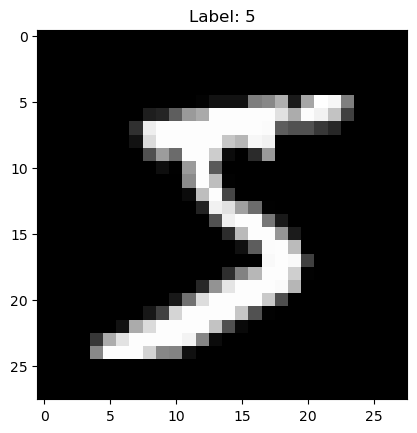

In [21]:
row_to_display = train_data.iloc[0, 1:]

image_matrix = np.array(row_to_display).reshape(28, 28)

plt.imshow(image_matrix, cmap='gray')
plt.title(f"Label: {train_data.iloc[0, 0]}")
plt.show()

### Bibliotek

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
import keras
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image

from art.estimators.classification import KerasClassifier
from art.attacks.evasion import BoundaryAttack
from art.utils import to_categorical
import keras.backend as K
print(f"TensorFlow: {tf.version}")


TensorFlow: <module 'tensorflow._api.v2.version' from 'C:\\Users\\dator\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python311\\site-packages\\tensorflow\\_api\\v2\\version\\__init__.py'>


### Egna funktioner

In [75]:
# Samla era egna funktioner relaterade till attacken här
# Funktionerna ska kort beskrivas med docstrings och kommentarer så att man förstår syftet och implementationen
# Blir det många bör ni bryta ut dessa i en separat fil

def projected_gradient_descent(model, x, target_class_id, max_iter, step_size, eps, clamp= (0, 255)):
    """Utför PGD på en bild

    Parametrar:
    model (tf.Tensor()): modellen som skall luras
    x (np.array()): bilden som skall missklassifieras
    target_class_id (int): id:et på klassen som funktionen skall ändra till
    max_iter (int): antalet iterationer som programmet ska köra, vår implementation stoppar inte efter att ha uppnått ett visst värde och kör istället alltid till max_iter
    step_size (int): stepsize bestämmer hur mycket algoritmen hoppar mellan iterationer,
    en låg stepsize innebär att små steg tas mot optimat vilket kan kräva fler iterationer medan en stor kan leda till att man missar den.
    eps (float): maximala avståndet en pixel kan ha från sitt ursprungsvärde
    clamp (tuple[2]): sätt detta till gränserna för arrayens möjliga värden

    return:
    np.array()
    """
    x_adv = tf.identity(x) # instansierar en kopia av bilden som skall pertuberas. Vi lägger inte till något brus.

    for i in range(max_iter):
        #Diferentierar automatiskt vilket krävs för att beräkna gradienterna av x_adv.
        with tf.GradientTape() as tape:
            # Gör så att operationer som berör x_adv spåras explicit
            tape.watch(x_adv)
            prediction = model(x_adv)
            # beräknar den negativa medelprediceringen för målklassen, vilket skapar en slags förlustfunktion för att maximera sannolikheten för target_class_id.
            loss = -tf.keras.backend.mean(prediction[:, target_class_id])

        gradients = tape.gradient(loss, x_adv)
        gradients = tf.sign(gradients) * step_size
        #Lägger till det nya bruset som skall vara närmare till target_class_id. Det som egentligen görs är en gradient ascent med avseende på målklassens sannolikhet pga minustecknet i loss.
        x_adv -= gradients

        x_adv = tf.clip_by_value(x_adv, x - eps, x + eps) #Självaste projiceringen
        x_adv = tf.clip_by_value(x_adv, * clamp) #Vi kör med 0,255 bilder och detta är en enkel metod att se till så att vi inte överskrider det.
        print(f"Iteration {i} Loss: {loss}")
    return x_adv.numpy()

def display_top_x(image,model,x):
    """Visar de mest sannolika alternativen för en viss modell
    image (np.array): bilden som skall prediceras
    model (tf.Tensor.model): modellen som är menad att predicera bilden
    """
    predictions = model.predict(np.array([image]))[0]
    predictions = [(i,_) for i,_ in enumerate(predictions)]
    predictions = sorted(predictions,key=lambda i: i[1],reverse=True)
    for i in range(x):
        print(predictions[i])


def contrast_images(init, target):
    """Presenterar 3 bilder
    init, target (np.array): två bilder i array format"""
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(init.astype(np.uint))
    plt.title('Initial image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(target.astype(np.uint))
    plt.title('Pertubed image')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(np.abs(init - target).astype(np.uint),cmap='hot')
    plt.title('Difference')
    plt.axis('off')
    plt.show()


### Förberedelser

In [42]:
# E.g. inläsning av modell och dataset
model = ResNet50(weights='imagenet')
init_image = image.load_img("images/koala.jpeg", target_size=(224, 224))
init_image = image.img_to_array(init_image)


### Modellering

In [68]:
# E.g. träning


In [88]:
# Attackutförande
adversarial_img =projected_gradient_descent(model, np.array([init_image]),866,max_iter=20,step_size=0.5, eps = 2)


Iteration 0 Loss: -2.3867534684751668e-11
Iteration 1 Loss: -2.385840616625501e-06
Iteration 2 Loss: -0.00012752445763908327
Iteration 3 Loss: -0.0012011949438601732
Iteration 4 Loss: -0.008491932414472103
Iteration 5 Loss: -0.026711804792284966
Iteration 6 Loss: -0.08100919425487518
Iteration 7 Loss: -0.3976178765296936
Iteration 8 Loss: -0.7068113684654236
Iteration 9 Loss: -0.9002120494842529
Iteration 10 Loss: -0.9602339863777161
Iteration 11 Loss: -0.9843270182609558
Iteration 12 Loss: -0.9902580976486206
Iteration 13 Loss: -0.9961985945701599
Iteration 14 Loss: -0.9977230429649353
Iteration 15 Loss: -0.9989160299301147
Iteration 16 Loss: -0.9991812109947205
Iteration 17 Loss: -0.9993890523910522
Iteration 18 Loss: -0.9996101260185242
Iteration 19 Loss: -0.9997479319572449


### Attackresultat

Resnet identifierar den pertuberade bilden identifieras med hög träffsäkerhet efter 500 iterationer av PGD. Pertuberingarna är knappt synliga i jämförelse bilden. Vi valde därför att inkludera en bild som enbart innehåller pertuberingarna. Där tydliggörs de små skillnaderna.
Attacken lyckas generera en bild på 7 sekunder med hög träffsäkerhet som en traktor

Initial predictions
1/1 [==============================] - 0s 77ms/step
(105, 0.99993694)
(356, 1.8836014e-05)
(335, 1.6169033e-05)
Prediction after a 100 iterations
1/1 [==============================] - 0s 73ms/step
(866, 0.9997384)
(730, 0.00013752839)
(856, 8.003569e-05)


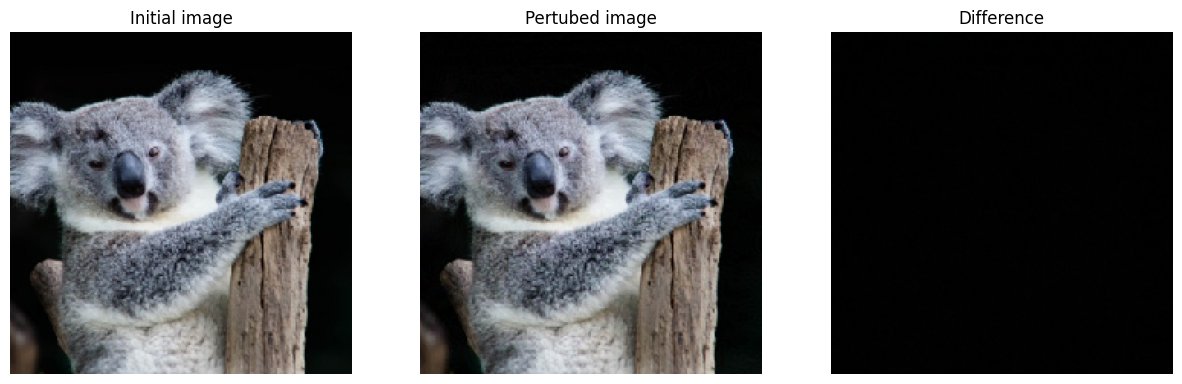

In [89]:
print("Initial predictions")
display_top_x(init_image,model,3)

print("Prediction after a 100 iterations")
display_top_x(adversarial_img[0],model,3)
contrast_images(init_image,adversarial_img[0])


## Skyddsåtgärder

Beskriv (i rapportens sektion 2.3) vilka säkerhetsåtgärd(er) ni valt som lämpliga för att skydda mot er attack. Motivera varför ni valt just de(n) metod(erna).

## Implementation av skyddsåtgärder (frivilligt endast för A eller B)

Nedan fyller ni i er kod som implementerar skyddsmekanismen mot er attackmetod. Skriv även en summering av vad skyddsresultatet blev när ni implementerade metoden (beskriv detta i rapportens del 2.4).

### Egna funktioner

In [71]:
# Samla era egna funktioner relaterade till säkerhetsåtgärden här
# Funktionerna ska kort beskrivas med docstrings och kommentarer så att man förstår syftet och implementationen
# Blir det många bör ni bryta ut dessa i en separat fil


### Förberedelser

In [72]:
# E.g. skapande av ny modell, etc.


### Skydd

Beskriv säkerhetsåtgärden kortfattat här

In [73]:
# Implementation av skyddsåtgärd


### Skyddsresultat

Bevisa och förklara era skyddsresultat i flytande text här

In [74]:
# Presentera skyddåtgärdens resultat m.h.a. kod här


# Referenser

Lista era referenser här. E.g. var ni hittat information om attacken, skyddsåtgärder eller bibliotekets dokumentation/repository.

https://towardsdatascience.com/know-your-enemy-7f7c5038bdf3 